# Instalando bibliotecas de Fuzzy e MQTT


In [ ]:
pip install scikit-fuzzy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install paho-mqtt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando Bibliotecas


In [31]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt # Cliente que fará as publicações no broker
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org" # Servidor onde conectaremos o nosso cliente
client = mqtt.Client("gab_ilian")
client.connect(mqttBroker)

0

# Antecendetes 

## Erro de Potência


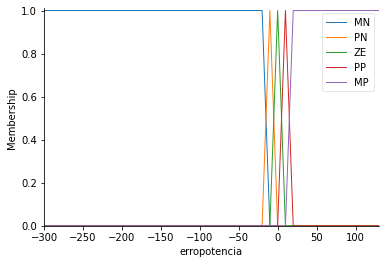

In [34]:
# Erro de potência - Variável que controla o erro na potência
erroPotencia = ctrl.Antecedent(np.arange(-300, 131, 1), 'erropotencia')

# Criando as variações
erroPotencia['MN'] = fuzz.trapmf(erroPotencia.universe, [-300, -300, -20,-10])
erroPotencia['PN'] = fuzz.trimf(erroPotencia.universe, [-20,-10,0])
erroPotencia['ZE'] = fuzz.trimf(erroPotencia.universe, [-10, 0, 10])
erroPotencia['PP'] = fuzz.trimf(erroPotencia.universe, [0, 10, 20])
erroPotencia['MP'] = fuzz.trapmf(erroPotencia.universe,[10, 20, 130,130])
# You can see how these look with .view()
erroPotencia.view()

## Variação do erro na potência


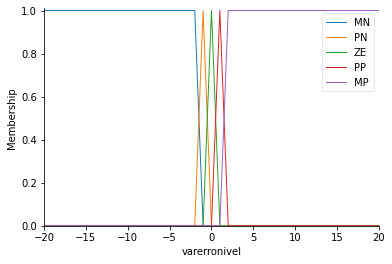

In [35]:
# Máximo Aceito de variação foi 20 mm (Aceita no máximo 5% de variação - 5%)

varErroPotencia =ctrl.Antecedent(np.arange(-20, 21, 1), 'varerronivel')
# Criando o gráfico 
varErroPotencia['MN'] = fuzz.trapmf(varErroPotencia.universe, [-20, -20, -2,-1])
varErroPotencia['PN'] = fuzz.trimf(varErroPotencia.universe, [-2,-1,0])
varErroPotencia['ZE'] = fuzz.trimf(varErroPotencia.universe, [-1, 0, 1])
varErroPotencia['PP'] = fuzz.trimf(varErroPotencia.universe, [0, 1, 2])
varErroPotencia['MP'] = fuzz.trapmf(varErroPotencia.universe,[1, 2, 20,20])
# You can see how these look with .view()
varErroPotencia.view()

# Consequente


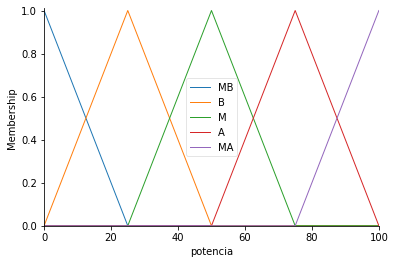

In [36]:

potencia =ctrl.Consequent(np.arange(0, 101, 1), 'potencia')

potencia['MB'] = fuzz.trimf(potencia.universe, [0,0,25])
potencia['B'] = fuzz.trimf(potencia.universe, [0,25,50])
potencia['M'] = fuzz.trimf(potencia.universe, [25, 50, 75])
potencia['A'] = fuzz.trimf(potencia.universe, [50, 75, 100])
potencia['MA'] = fuzz.trimf(potencia.universe, [75, 100, 100])
potencia.view()

# Regras de funcionamento


In [37]:
# Regras para a varErroPotencia MN - > Muito negativa (Diferença entre o objetivo e o atual está muito grande)

regra1 = ctrl.Rule(erroPotencia['MN']& varErroPotencia['MN'], potencia['MA']) # Erro[MN] & varErro [MN] -> MA
regra2 = ctrl.Rule(erroPotencia['PN']& varErroPotencia['MN'], potencia['MA']) # Erro[PN] & varErro [MN] -> MA
regra3 = ctrl.Rule(erroPotencia['ZE']& varErroPotencia['MN'], potencia['M']) # Erro[ZE] & varErro [MN] -> M
regra4 = ctrl.Rule(erroPotencia['PP']& varErroPotencia['MN'], potencia['M']) # Erro[PP] & varErro [MN] -> M
regra5 = ctrl.Rule(erroPotencia['MP']& varErroPotencia['MN'], potencia['M']) # Erro[MP] & varErro [MN] -> M

# Regras para a varErroPotencia PN - > Pouco negativa (Diferença entre o objetivo e o atual está um pouco pequena)
regra6 = ctrl.Rule(erroPotencia['MN']& varErroPotencia['PN'], potencia['MA']) # Erro[MN] & varErro [PN] -> MA 
regra7 = ctrl.Rule(erroPotencia['PN']& varErroPotencia['PN'], potencia['A']) # Erro[PN] & varErro [PN] -> A
regra8 = ctrl.Rule(erroPotencia['ZE']& varErroPotencia['PN'], potencia['A']) # Erro[ZE] & varErro [PN] -> A
regra9 = ctrl.Rule(erroPotencia['PP']& varErroPotencia['PN'], potencia['B']) # Erro[PP] & varErro [PN] -> B
regra10 =ctrl.Rule(erroPotencia['MP']& varErroPotencia['PN'], potencia['B']) # Erro[MP] & varErro [PN] -> B

# Regras para a varErroPotencia ZE - > Zero 
regra11 = ctrl.Rule(erroPotencia['MN']& varErroPotencia['ZE'], potencia['MA']) # Erro[MN] & varErro [ZE] -> MA
regra12 = ctrl.Rule(erroPotencia['PN']& varErroPotencia['ZE'], potencia['MA']) # Erro[PN] & varErro [ZE] -> MA
regra13 = ctrl.Rule(erroPotencia['ZE']& varErroPotencia['ZE'], potencia['M']) # Erro[ZE] & varErro [ZE] -> M
regra14 = ctrl.Rule(erroPotencia['PP']& varErroPotencia['ZE'], potencia['M']) # Erro[PP] & varErro [ZE] -> M
regra15 = ctrl.Rule(erroPotencia['MP']& varErroPotencia['ZE'], potencia['M']) # Erro[MP] & varErro [ZE] -> M

# Regras para a varErroPotencia PP - > Pouco positiva
regra16 = ctrl.Rule(erroPotencia['MN']& varErroPotencia['PP'], potencia['A']) # Erro[MN] & varErro [PP] -> A
regra17 = ctrl.Rule(erroPotencia['PN']& varErroPotencia['PP'], potencia['MA']) # Erro[PN] & varErro [PP] -> MA
regra18 = ctrl.Rule(erroPotencia['ZE']& varErroPotencia['PP'], potencia['M']) # Erro[ZE] & varErro [PP] -> M
regra19 = ctrl.Rule(erroPotencia['PP']& varErroPotencia['PP'], potencia['M']) # Erro[PP] & varErro [PP] -> M
regra20 = ctrl.Rule(erroPotencia['MP']& varErroPotencia['PP'], potencia['B']) # Erro[MP] & varErro [PP] -> B
 
# Regras para a varErroPotencia MP -> Muito Positiva
# erroPotencia -> Onde está aquele valor que foi setado por você anteriormente
regra21 = ctrl.Rule(erroPotencia['MN']& varErroPotencia['MP'], potencia['A']) # Erro[MN] & varErro [MP] -> A
regra22 = ctrl.Rule(erroPotencia['PN']& varErroPotencia['MP'], potencia['A']) # Erro[PN] & varErro [MP] -> A
regra23 = ctrl.Rule(erroPotencia['ZE']& varErroPotencia['MP'], potencia['A']) # Erro[ZE] & varErro [MP] -> A
regra24 = ctrl.Rule(erroPotencia['PP']& varErroPotencia['MP'], potencia['M']) # Erro[PP] & varErro [MP] -> M
regra25 = ctrl.Rule(erroPotencia['MP']& varErroPotencia['MP'], potencia['MB']) # Erro[MP] & varErro [MP] -> MB

In [38]:
nivel_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
controlador = ctrl.ControlSystemSimulation(nivel_ctrl)

# Entrada de dados

In [39]:
33# Entradas de dados para as operações
print('''   MENU DE CONTROLE DO RESERVATÓRIO
            [1] - MANTER NÍVEL ALTO
            [2] - MANTER NÍVEL MÉDIO
            [3] - MANTER NÍVEL BAIXO
            [4] - OUTRO MODO DE OPERAÇÃO''')
opcao=-1
while(not(opcao>=1 and opcao<=4)):
  
  opcao=int(input())

if(opcao==1):
  sp=400
elif(opcao==2):
  sp=360
elif(opcao==3):
  sp=320
elif(opcao==4):
  sp=int(input('Escolha o setpoint: '))


print('Nível atual da água: ')

nivelAtual=500
while(nivelAtual<100 or nivelAtual>450):
    print('100 mm a 450 mm')
    nivelAtual=float(input())

   MENU DE CONTROLE DO RESERVATÓRIO
            [1] - MANTER NÍVEL ALTO
            [2] - MANTER NÍVEL MÉDIO
            [3] - MANTER NÍVEL BAIXO
            [4] - OUTRO MODO DE OPERAÇÃO
1
Nível atual da água: 
100 mm a 450 mm
100


# Saída


In [40]:
print(nivelAtual)

erroatual=0
while True: 
  erroanterior=erroatual
  erroatual=nivelAtual-sp
  varerroTemp=erroatual-erroanterior
  controlador.input['erropotencia'] =erroatual
  controlador.input['varerronivel'] =varerroTemp
  controlador.compute()

  i=0
  while (i < 10):
    nivelAtual=nivelAtual * 0.9954 + controlador.output['potencia'] * 0.02763
    time.sleep(1)
    i += 1
  
  print(nivelAtual)
  client.publish("Controle/nivel", nivelAtual) # Tópico onde estará sendo publicado os dados do nivel da agua
  client.publish("Controle/erro", erroatual) # Tópico onde estará sendo publicado os dados de erro


100.0
120.30366174160729
135.1816164946481
149.389179729523
162.9565588769635
175.91260023939523
188.2848503225447
200.0996144034818
211.3820124596215
222.1560325776
232.4445819555787
242.2695356074165
251.65178287226124
269.16705170613363
277.3373133888454
285.1394280900532
292.58998428699965
299.70482299031477
306.4990714244031
312.9871751902135
319.1829289787737
325.09950590079285
330.7494854946888
336.14488047259226
341.297162261191
346.21728539172074
350.9157107909569
355.40242802272877
359.68697652724495
363.77846590338805
367.6855952771005
371.41667179704433
374.97962829685645
378.3820401615548
381.6311414339532
384.7338401953322
387.6967332530659
390.52612016643303
393.22801664043436
395.80816731609184
398.27205798442554
400.6249272500761
402.28402672258886
401.95167850464463
398.18231314927374
395.29768068682864
394.4500705114359
395.5329088748021
394.53946243855563
396.97781491550785
399.38900198022765
401.69154243432587
402.46943145004724
397.86691498039875
395.2184832888164

KeyboardInterrupt: ignored